Original Emotion Counts:
 emotion
angry        376
fearful      376
sad          376
happy        376
calm         376
disgust      192
surprised    192
neutral      188
Name: count, dtype: int64
Balanced Emotion Counts:
 emotion
fearful      376
calm         376
disgust      376
neutral      376
angry        376
happy        376
surprised    376
sad          376
Name: count, dtype: int64
Confusion Matrix:
 [[68  0  1  2  0  0  0  4]
 [ 0 70  1  0  1  3  0  0]
 [ 0  0 70  2  0  0  1  2]
 [ 0  0  2 66  0  1  5  2]
 [ 0  2  6  2 62  0  2  1]
 [ 0  1  0  0  0 71  3  0]
 [ 0  5  2  4  1  3 59  2]
 [ 0  2  0  0  1  0  0 72]]
Classification Report:
               precision    recall  f1-score   support

       angry       1.00      0.91      0.95        75
        calm       0.88      0.93      0.90        75
     disgust       0.85      0.93      0.89        75
     fearful       0.87      0.87      0.87        76
       happy       0.95      0.83      0.89        75
     neutral       0.91

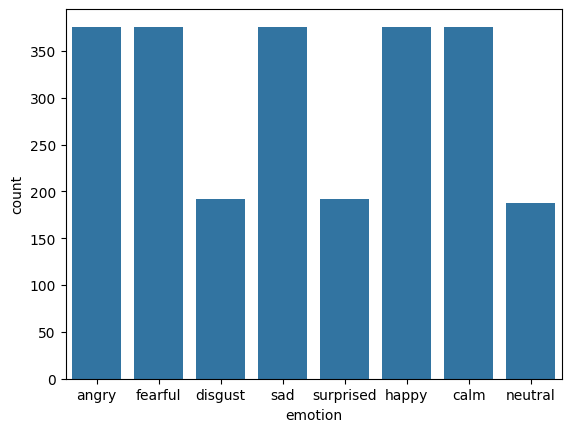

In [17]:
# 📦 Imports
import os
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import pickle

# 📁 Emotion code mapping
def emotion_finder(file_name):
    emotion = {
        "01": "neutral",
        "02": "calm",
        "03": "happy",
        "04": "sad",
        "05": "angry",
        "06": "fearful",
        "07": "disgust",
        "08": "surprised"
    }
    index = file_name.split("-")[2]
    return emotion.get(index, "unknown")

# 📂 Data loading
folders = [
    '/Users/yathamlohithreddy/Desktop/vscodefloder/marsproject/Audio_Speech_Actors_01-24',
    '/Users/yathamlohithreddy/Desktop/vscodefloder/marsproject/Audio_Song_Actors_01-24'
]

emotions_list = []
file_names = []

for pre in folders:
    for actor_name in os.listdir(pre):
        actor_path = os.path.join(pre, actor_name)
        if not os.path.isdir(actor_path):
            continue
        for filename in os.listdir(actor_path):
            if filename.endswith(".wav"):
                full_path = os.path.join(actor_path, filename)
                emotion = emotion_finder(filename)
                if emotion != "unknown":  # Only keep known emotions
                    file_names.append(full_path)
                    emotions_list.append(emotion)

# 📊 Check distribution
df = pd.DataFrame({"file_path": file_names, "emotion": emotions_list})
print("Original Emotion Counts:\n", df["emotion"].value_counts())
sns.countplot(x="emotion", data=df)

# ⚖️ Balance dataset
max_count = df['emotion'].value_counts().max()
df_balanced = pd.concat([
    resample(df[df.emotion == e], replace=True, n_samples=max_count, random_state=42)
    for e in df['emotion'].unique()
]).sample(frac=1, random_state=42)

print("Balanced Emotion Counts:\n", df_balanced["emotion"].value_counts())

# 🎵 Feature Extraction Functions
def mfcc_values(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    return np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)

def delta_values(filename):
    mfcc = mfcc_values(filename)
    return librosa.feature.delta(mfcc)

def log_mel_values(file_path, duration=3, offset=0.5, n_mels=128):
    y, sr = librosa.load(file_path, duration=duration, offset=offset)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    return np.mean(librosa.power_to_db(mel_spec).T, axis=0)

def zcr_values(file_name):
    sig, sr = librosa.load(file_name, duration=3, offset=0.5)
    return np.mean(librosa.feature.zero_crossing_rate(sig).T, axis=0)

def spectral_features(file_path, duration=3, offset=0.5):
    y, sr = librosa.load(file_path, duration=duration, offset=offset)
    centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr), axis=1)
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    flatness = np.mean(librosa.feature.spectral_flatness(y=y))
    return np.hstack([centroid, bandwidth, rolloff, flatness, contrast])

def extract_features(file_name):
    return np.hstack([
        mfcc_values(file_name),
        delta_values(file_name),
        log_mel_values(file_name),
        zcr_values(file_name),
        spectral_features(file_name)
    ])

# 🧠 Feature Extraction Loop
features, labels = [], []

for i, row in df_balanced.iterrows():
    try:
        f = extract_features(row["file_path"])
        features.append(f)
        labels.append(row["emotion"])
    except Exception as e:
        print("Error processing:", row["file_path"], e)

X = np.array(features)
y = np.array(labels)

# 🔁 Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 🧪 Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# 🌳 Train model
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# 📈 Evaluation
y_pred = clf.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# 💾 Save model and label encoder
os.makedirs("model", exist_ok=True)
joblib.dump(clf, "model/trained_model.pkl")
with open("model/label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

print("✅ Model and LabelEncoder saved successfully.")
print("🎯 Classes:", le.classes_)
